In [ ]:
import cv2
import numpy as np
import scipy
import matplotlib.pyplot as plt
import glob

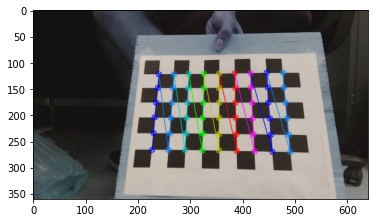

In [ ]:
img = cv2.imread("./calib_imgs/1/left1.jpg")       
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Find the chess board corners
ret, corners = cv2.findChessboardCorners(gray, (6,9),None)

# If found, add object points, image points (after refining them)
if ret == True:
    # objpoints.append(objp)

    corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
    # imgpoints.append(corners2)

    # Draw and display the corners
    img = cv2.drawChessboardCorners(img, (6,9), corners2,ret)
    plt.imshow(img)

In [ ]:
def calib_cam(path):
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.

    images = glob.glob(path)
    #remember to sort the list so that the extrinsic parameters for left and right match!!!
    images.sort()

    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (6,9),None)

        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)

            corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
            imgpoints.append(corners2)

    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

In [ ]:
ret_l, mtx_l, dist_l, rvecs_l, tvecs_l = calib_cam('./calib_imgs/1/left*.jpg')
print(mtx_l)
print(dist_l)

[[9.46114290e+03 0.00000000e+00 8.84426418e+01]
 [0.00000000e+00 6.57890800e+02 1.88254415e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 2.78806928e+01 -4.84863143e+03 -1.70697509e-02 -2.11077050e-02
   1.94167211e+05]]


In [ ]:
ret_r, mtx_r, dist_r, rvecs_r, tvecs_r = calib_cam('./calib_imgs/1/right*.jpg')
print(mtx_r)
print(dist_r)

[[1.84423267e+04 0.00000000e+00 5.44218546e+02]
 [0.00000000e+00 2.30465660e+03 1.60615105e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 3.53460027e+02 -1.46205014e+05  8.58958609e-01  1.33044896e+00
  -1.39148700e+05]]


# 2)

In [ ]:
def skew(t):
  m = np.zeros((3,3))

  m[0][1] = -t[2]
  m[0][2] =  t[1]
  m[1][2] = -t[0]

  m[1][0] =  t[2]
  m[2][0] = -t[1]
  m[2][1] =  t[0]

  return m

def get_lr_transform(j):
  rot_l = cv2.Rodrigues(rvecs_l[j])[0]
  rot_r = cv2.Rodrigues(rvecs_r[j])[0]

  # go from left camera --> world coords --> right camera
  rot_lr = rot_r @ np.linalg.inv(rot_l)
  tran_lr = tvecs_r[j] - rot_r @ np.linalg.inv(rot_l) @ tvecs_l[j]
  # Translations between cameras only defined up to scale
  tran_lr /= np.sqrt((tran_lr**2).sum())

  return rot_lr, tran_lr

In [ ]:
# Verify that the translation and rotations are consistent between image pairs

# find an image pair that best fits the rest
rot_lr0, tran_lr0 = get_lr_transform(4)


# verify angainst other image pairs
for i in range(0,29):
  rot_lr, tran_lr = get_lr_transform(i)

  # calculate cosine distances between rotation and transaltion vectors
  rot_diff =  np.rad2deg(np.arccos((np.trace(rot_lr.T @ rot_lr0) - 1) / 2))
  tran_diff = tran_lr.T @ tran_lr0


  print("\nRotation distance (lower is better): ", rot_diff, "\ntranslation distance (close to 1 is better): ", tran_diff[0][0])


Rotation distance (lower is better):  124.50078418111616 
translation distance (close to 1 is better):  0.973640333698814

Rotation distance (lower is better):  29.12524362687314 
translation distance (close to 1 is better):  0.9450204679654128

Rotation distance (lower is better):  18.82311015049235 
translation distance (close to 1 is better):  0.9933249273190542

Rotation distance (lower is better):  18.341959892277387 
translation distance (close to 1 is better):  0.9991258545430195

Rotation distance (lower is better):  nan 
translation distance (close to 1 is better):  0.9999999999999999

Rotation distance (lower is better):  3.6957141546621943 
translation distance (close to 1 is better):  0.9997012935332207

Rotation distance (lower is better):  2.6056481605966773 
translation distance (close to 1 is better):  0.9998569919972553

Rotation distance (lower is better):  3.0656897008315274 
translation distance (close to 1 is better):  0.999808224078893

Rotation distance (lower i

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in arccos
  if sys.path[0] == '':


In [ ]:
# rotation and translation between left and right cameras
print(rot_lr0)
print(tran_lr0)

[[ 0.99836761 -0.02698758 -0.05033675]
 [ 0.02898351  0.99880496  0.03935244]
 [ 0.04921456 -0.04074713  0.99795671]]
[[-0.0085954 ]
 [-0.00732393]
 [ 0.99993624]]


In [ ]:
# Essential and fundamental matrices
E = skew(tran_lr0) @ rot_lr0
print('Essential Matrix')
print(E)
F = np.linalg.inv(mtx_l) @ E @  np.linalg.inv(mtx_r)
print('\nFundamental Matrix')
print(F)

Essential Matrix
[[-2.93421105e-02 -9.98442841e-01 -4.66588944e-02]
 [ 9.98726969e-01 -2.73360966e-02 -4.17557037e-02]
 [ 7.06285126e-03 -8.78277913e-03 -7.06912657e-04]]

Fundamental Matrix
[[-3.74815890e-09 -1.01661935e-08  5.34923818e-06]
 [-2.72714871e-08  1.07244927e-06 -1.85970103e-05]
 [ 3.82969643e-07 -3.81088407e-06 -3.03246293e-04]]
